## Подготовка

In [ ]:
import pandas as pd
import numpy as np 
from sklearn.ensemble import RandomForestRegressor
!pip install catboost
from statsmodels.tsa.stattools import adfuller
from catboost import CatBoostRegressor, Pool
from statsmodels.tsa.seasonal import seasonal_decompose
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
import catboost as cat
from lightgbm import LGBMRegressor
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv("taxi.csv",parse_dates =[0],index_col= 0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
df = df.sort_index()

Проверим упорядочен ли наш index сейчас

In [ ]:
df.index.is_monotonic

True

In [ ]:
display(df)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Сделаем интервалы в 1 час для удобного масштаба

In [ ]:
df = df.resample("1H").sum()


Проверим наличие пустых значений

In [ ]:
df.isna().sum()

num_orders    0
dtype: int64

In [ ]:
df_1 = df.copy()
df_2 = df.copy()
df["rolling_mean"] = df["num_orders"].rolling(20).mean()
df["rolling_std"] = df["num_orders"].rolling(20).std()

Мы подготовили данные для временного ряда:

- В качестве индекса поставили столбец Datetime

- Отсортировали индекс и проверили данные на монотонность 
- Провели ресемплинг с диапозоном в 1 час, где данные агрегировали с помощью суммы
- Проверили наличие пустых значений
- Сохранили в переменных копии датасета, чтобы потом сравнить и выявить наиболее стационарную, и для создания корректных признаков

## Анализ

Отобразим данные на графике

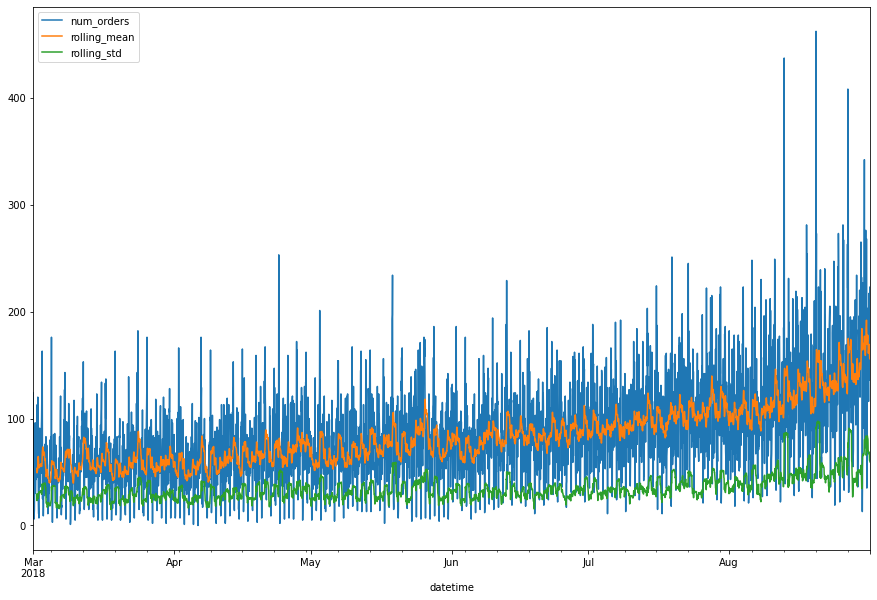

In [ ]:
df.plot(figsize=(15,10))

Пока что данные выглядят стационарно, но проверим что будет через разность ряда

In [ ]:
df_1 = df - df.shift()

In [ ]:
df_1["rolling_mean"] = df_1["num_orders"].rolling(20).mean()
df_1["rolling_std"] = df_1["num_orders"].rolling(20).std()

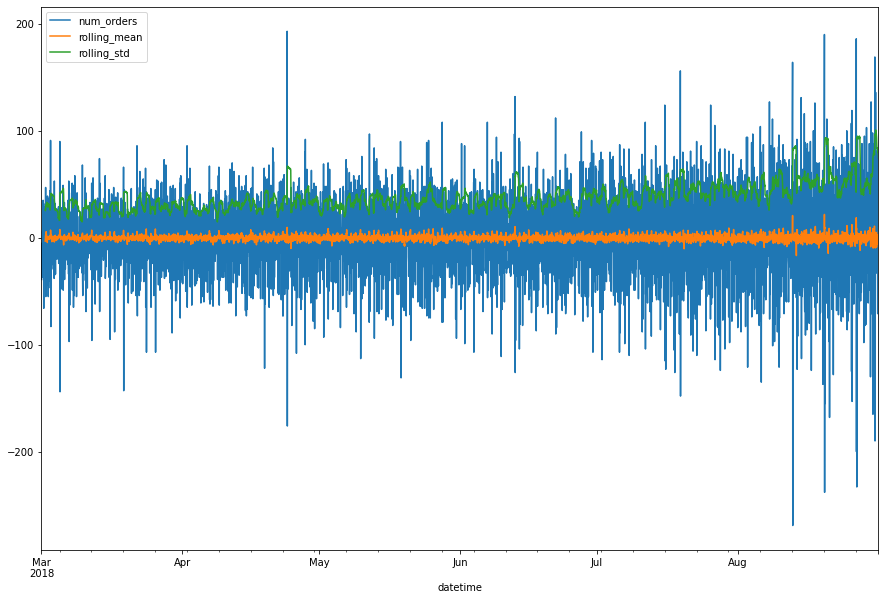

In [ ]:
df_1.plot(figsize=(15,10))

Расширенным тестом Дики-Фуллера проверим стационарность (в аргументе укажем тип регрессии - линейный тренд)

In [ ]:
fm = df_2['num_orders']
st_test = adfuller(fm, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, то ряд стационарный')
if st_test[1] < 0.05:
    print('Подтверждена')
else:
    print('Отвергнута')

Если значение с индексом 1 меньше P-Value, то ряд стационарный
Подтверждена


In [ ]:
df_1.describe()

,num_orders,rolling_mean,rolling_std
count,4415.000000,4396.000000,4396.000000
mean,0.018347,0.024488,37.989795
std,39.023437,2.801253,12.318616
min,-269.000000,-16.650000,14.839049
25%,-22.000000,-1.750000,29.647457
50%,1.000000,-0.050000,35.859650
75%,23.000000,1.650000,43.480720
max,193.000000,21.800000,100.717675



Признаки, полученные для анализа построим заново, так как текущие формировались на истинном целевом признаке

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [ ]:
make_features(df_2,24,20)

Изучим данные на графиках тренда и сезонности

Глобальные тренды

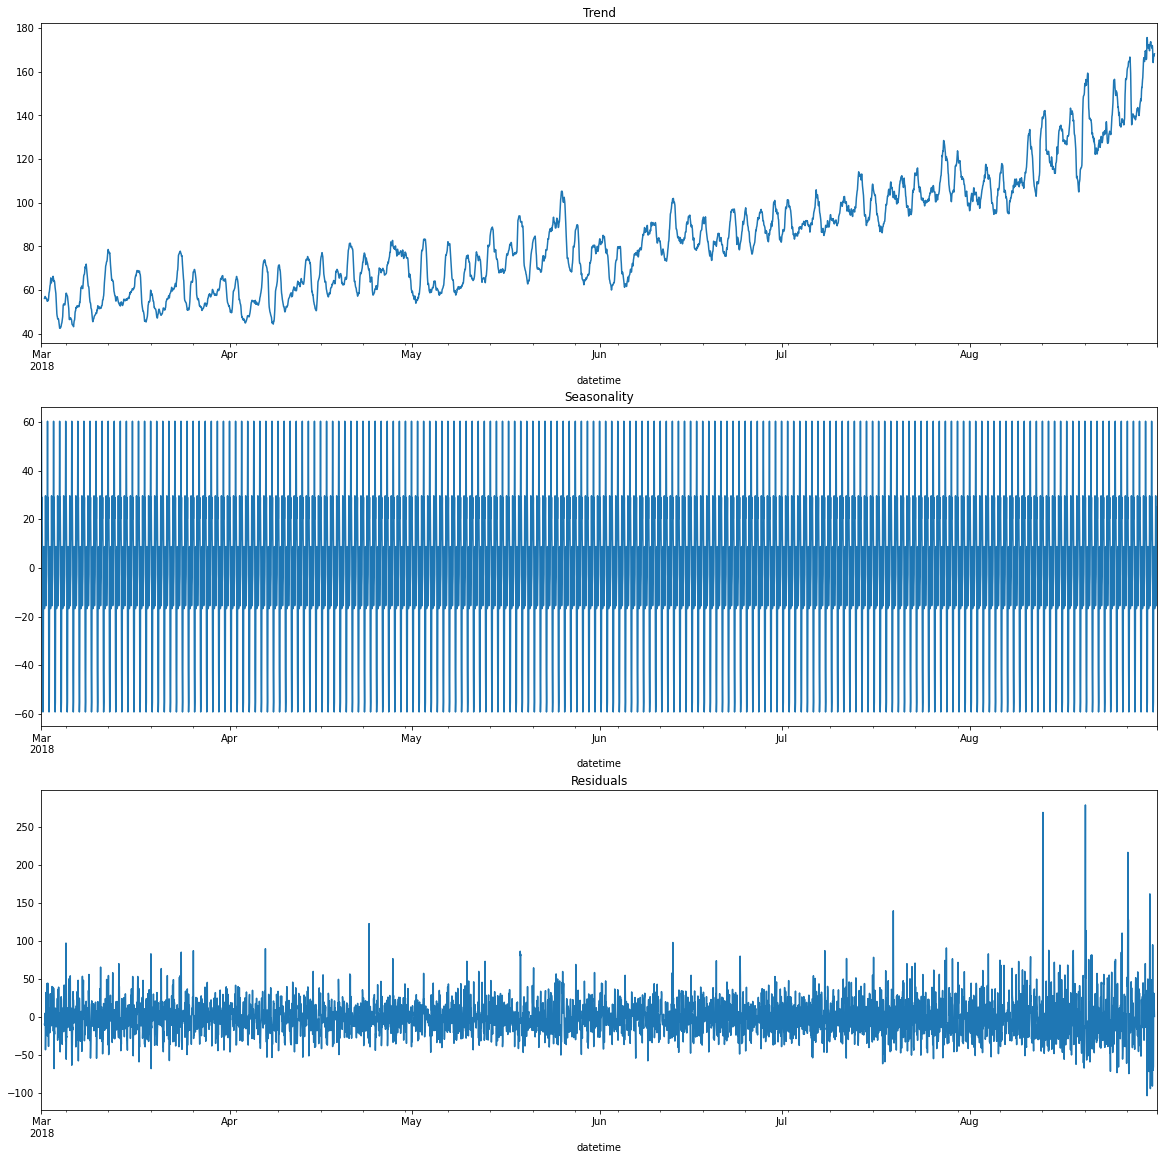

In [ ]:
decomposed = seasonal_decompose(df_2["num_orders"])
fig,ax = plt.subplots(3,1,figsize = (20,20))

decomposed.trend.plot(ax=ax[0],title = 'Trend')
decomposed.seasonal.plot(ax=ax[1],title = 'Seasonality')
decomposed.resid.plot(ax=ax[2],title = 'Residuals')


Недельные и дневные тренды

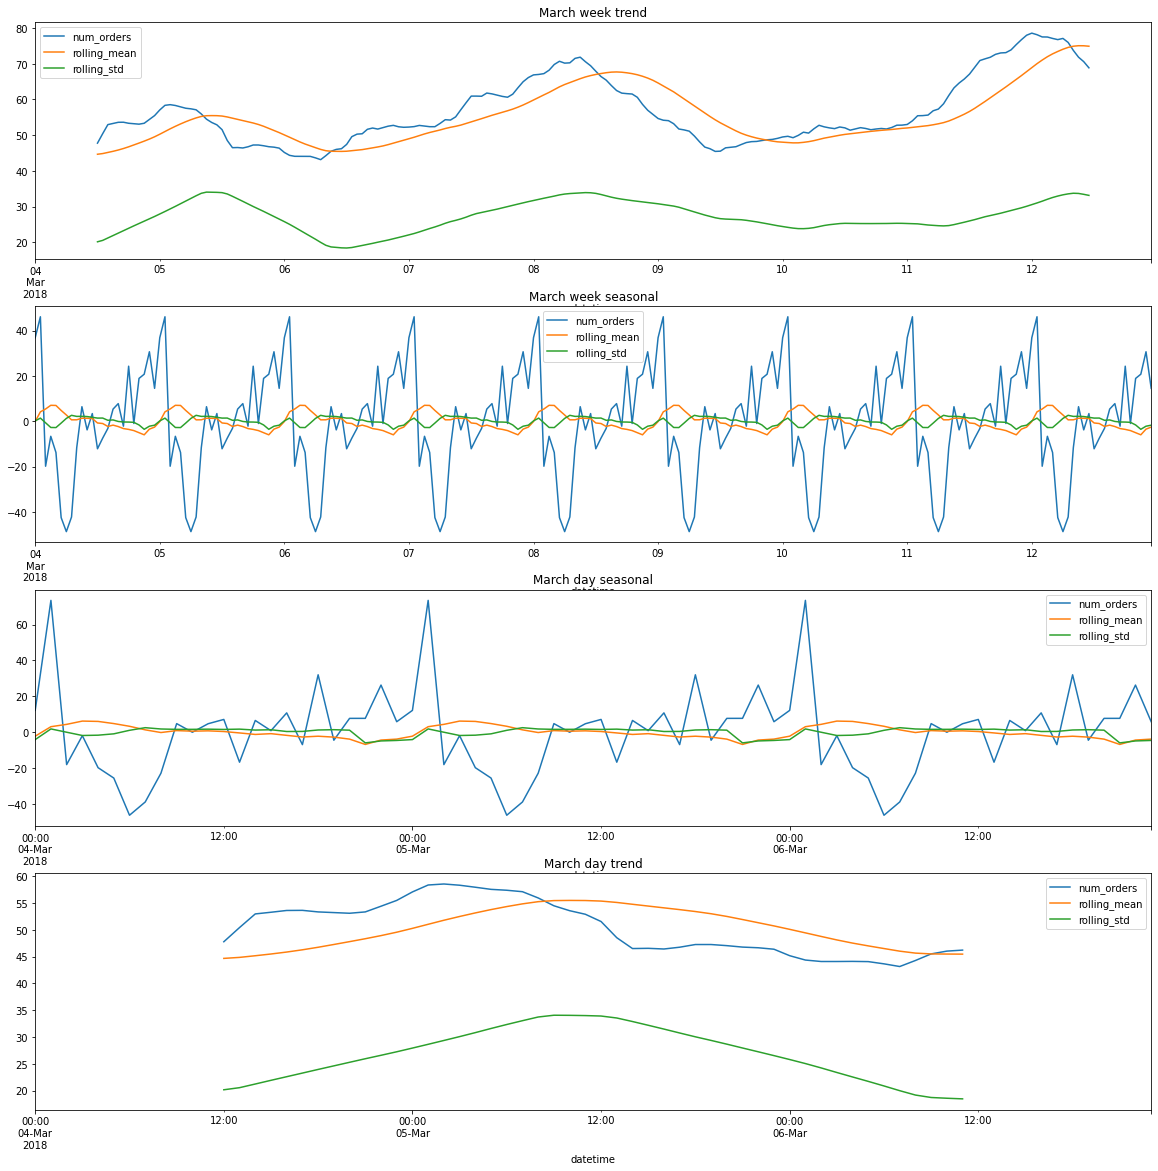

In [ ]:
fig,ax = plt.subplots(4,1,figsize = (20,20))
decomposedWeek = seasonal_decompose(df['2018-03-04':'2018-03-12'])
decomposedFewDays = seasonal_decompose(df['2018-03-04':'2018-03-06'])
decomposedWeek.trend.plot(ax=ax[0],title = 'March week trend')
decomposedWeek.seasonal.plot(ax=ax[1],title = 'March week seasonal')
decomposedFewDays.seasonal.plot(ax=ax[2],title = 'March day seasonal')
decomposedFewDays.trend.plot(ax=ax[3],title = 'March day trend')



Возьмём пару месячных трендов

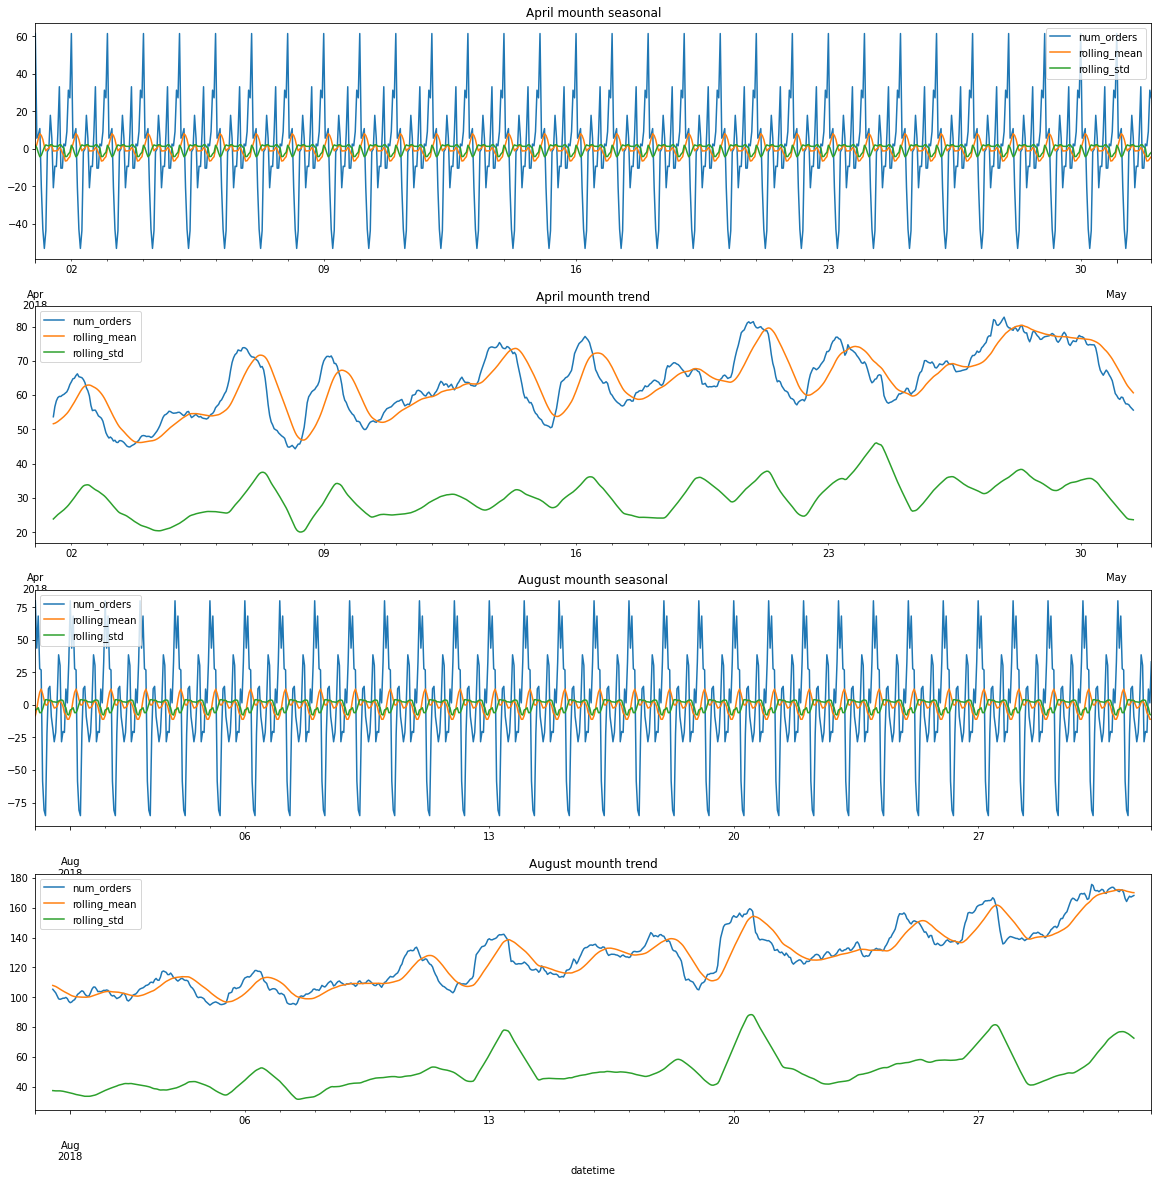

In [ ]:
fig,ax = plt.subplots(4,1,figsize = (20,20))
decomposedMonth_apr = seasonal_decompose(df['2018-04-01':'2018-05-01'])
decomposedMonth_aug = seasonal_decompose(df['2018-07-31':'2018-08-31'])
decomposedMonth_apr.seasonal.plot(ax=ax[0],title = 'April mounth seasonal')
decomposedMonth_apr.trend.plot(ax=ax[1],title = 'April mounth trend')
decomposedMonth_aug.seasonal.plot(ax=ax[2],title = 'August mounth seasonal')
decomposedMonth_aug.trend.plot(ax=ax[3],title = 'August mounth trend')

**Глобальные тренды**:
- В летний период количество заказов растет

**Недельные и дневные тренды**:
- Наличие слабого спроса: вторник , суббота и воскресенье, а так же тренд на рост числа заказов в понедельник.
- В рамках дня наблюдаются утренние пики активности с 6 утра до 12 дня, так же пик в конце дня ближе к полуночи.

**Тренд по месяцам**:
- Для двух месяцев видим схожую ситуацию по дням недели, как и недельном графике. К концу каждого месяца, относительного общего роста , увеличивается число заказов, а летом этот рост намного значительнее, чем весной.

**Итог**:
- Месячный тренд месяца оказал влияние на рост относительно теплых-холодных времён года.
- Тренд дня недели влияет на активность в том числе и объем заказов.
- Дневной тренд имеет сильное влияние, так как у нас прогнозирование на час вперед и присутствуют утренние и вечерние пики активности.


## Обучение

In [ ]:
train,test = train_test_split(df_2,shuffle = False, random_state = 42, test_size = 0.1)
print("Размер исходных данных:",df_2.shape[0])
print("Размер тренировочной:",train.shape[0])
print("Размер тестового датафрейма:",test.shape[0])
print("Доля(%) тестового датафрейма от исходный данных:", test.shape[0]/df_2.shape[0]*100)

Размер исходных данных: 4416
Размер тренировочной: 3974
Размер тестового датафрейма: 442
Доля(%) тестового датафрейма от исходный данных: 10.009057971014492


In [ ]:
train = train.dropna()

In [ ]:
(train_features,
test_features) = (train.drop('num_orders',axis = 1),
                  test.drop('num_orders',axis = 1))
(train_target,
test_target) = (train['num_orders'],
                test['num_orders'])

In [ ]:
# TimeSeriesSplit
splits = TimeSeriesSplit(n_splits=3)
# RandomForest
forest = RandomForestRegressor(random_state=42)
parametrs = {"max_depth": [1,10],"n_estimators":[100,150,10]}

forest_grid = GridSearchCV(forest,parametrs,cv = splits,verbose=True,n_jobs=-1, scoring='neg_mean_squared_error')
forest_grid.fit(train_features,train_target)

# CatBoost
catboost = CatBoostRegressor(loss_function='RMSE',random_state = 42)
parameters_cat = {'depth':[5,10], 'learning_rate':np.arange(0.1,1,0.2)}
catboost_grid = catboost.grid_search(parameters_cat,
            Pool(train_features,train_target),cv=splits,verbose=True)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   17.6s finished


Выходные данные были обрезаны до нескольких последних строк (5000).
21:	learn: 15.7003109	test: 40.5458442	best: 40.5458442 (21)	total: 1.4s	remaining: 1m 2s
22:	learn: 15.3716079	test: 40.4919892	best: 40.4919892 (22)	total: 1.47s	remaining: 1m 2s
23:	learn: 15.0751127	test: 40.2876329	best: 40.2876329 (23)	total: 1.53s	remaining: 1m 2s
24:	learn: 14.7975164	test: 40.1984848	best: 40.1984848 (24)	total: 1.59s	remaining: 1m 1s
25:	learn: 14.5718985	test: 39.8937672	best: 39.8937672 (25)	total: 1.66s	remaining: 1m 2s
26:	learn: 14.4270265	test: 39.7726316	best: 39.7726316 (26)	total: 1.72s	remaining: 1m 2s
27:	learn: 14.2915615	test: 39.7269141	best: 39.7269141 (27)	total: 1.78s	remaining: 1m 1s
28:	learn: 14.1085733	test: 39.5890814	best: 39.5890814 (28)	total: 1.85s	remaining: 1m 1s
29:	learn: 13.8174870	test: 39.5248349	best: 39.5248349 (29)	total: 1.91s	remaining: 1m 1s
30:	learn: 13.5695421	test: 39.3823825	best: 39.3823825 (30)	total: 1.97s	remaining: 1m 1s
31:	learn: 13.3437388	t

In [ ]:

%%time
# LightGBM
lgb_train = lgb.Dataset(train_features,train_target)
lgb_test = lgb.Dataset(test_features,test_target, reference=lgb_train)
parameters_light = {'metric': 'l2', 'max_depth':10,"random_state": 42,"learning_rate":0.1}
GBM = lgb.train(parameters_light,
                lgb_train,
                num_boost_round=1000,
                valid_sets=[lgb_train,lgb_test],
                verbose_eval=100)

[100]	training's l2: 161.108	valid_1's l2: 1778.99
[200]	training's l2: 71.9449	valid_1's l2: 1777.98
[300]	training's l2: 34.3034	valid_1's l2: 1738.74
[400]	training's l2: 16.9175	valid_1's l2: 1736.43
[500]	training's l2: 8.49085	valid_1's l2: 1737.77
[600]	training's l2: 4.53091	valid_1's l2: 1735.09
[700]	training's l2: 2.37252	valid_1's l2: 1732.07
[800]	training's l2: 1.33232	valid_1's l2: 1732.93
[900]	training's l2: 0.694547	valid_1's l2: 1730.97
[1000]	training's l2: 0.370973	valid_1's l2: 1731.97
CPU times: user 5.94 s, sys: 150 ms, total: 6.09 s
Wall time: 3.25 s


In [ ]:
%%time
final_cat = CatBoostRegressor(depth=catboost_grid["params"]["depth"], 
                              learning_rate=catboost_grid["params"]['learning_rate'],
                              loss_function='RMSE',verbose=100)
final_cat.fit(Pool(train_features,train_target))

0:	learn: 33.8780260	total: 4.62ms	remaining: 4.61s
100:	learn: 16.4980834	total: 446ms	remaining: 3.97s
200:	learn: 12.5952026	total: 925ms	remaining: 3.68s
300:	learn: 9.9804398	total: 1.36s	remaining: 3.15s
400:	learn: 8.0715129	total: 1.8s	remaining: 2.69s
500:	learn: 6.6197248	total: 2.23s	remaining: 2.23s
600:	learn: 5.4845645	total: 2.67s	remaining: 1.77s
700:	learn: 4.5502870	total: 3.11s	remaining: 1.33s
800:	learn: 3.8344591	total: 3.54s	remaining: 879ms
900:	learn: 3.2345019	total: 3.96s	remaining: 436ms
999:	learn: 2.7470465	total: 4.39s	remaining: 0us
CPU times: user 8.15 s, sys: 334 ms, total: 8.49 s
Wall time: 4.56 s


**Вывод**:

- Нашли подходящие гиперпараметры
- Обучили модели на данных
- Валидация результатов пройдена
- Переходим к тестированию

## Тестирование

Вычислим время предсказаний. Предскажем значения тестовой выборки разными моделями

In [ ]:
# Тренировочная
    # RandomForest
predict_forest_train = forest_grid.best_estimator_.predict(train_features)
    # CatBoost
predict_сat_train = final_cat.predict(train_features)
    #LightGBM
predict_GBM_train = GBM.predict(train_features)


# Тестовая
    # RandomForest
forest_test_start_time = time.time()
predict_forest_test = forest_grid.best_estimator_.predict(test_features)
forest_test_total_time = time.time() - forest_test_start_time
    # CatBoost
CatBoost_test_start_time = time.time()
predict_cat_test = final_cat.predict(test_features)
CatBoost_test_total_time = time.time() - CatBoost_test_start_time
    #LightGBM
GBM_test_start_time = time.time()
predict_GBM_test = GBM.predict(test_features)
GBM_test_total_time = time.time() - GBM_test_start_time



Посчитаем итоговую RMSE для нашего пула выборок

In [ ]:
#Тренировочная
    # RandomForest
RMSE_forest_train = (mean_squared_error(train_target, predict_forest_train))**0.5
    # CatBoost
RMSE_CatBoost_train = (mean_squared_error(train_target, predict_сat_train))**0.5
    #LightGBM
RMSE_GBM_train = (mean_squared_error(train_target, predict_GBM_train))**0.5

# Тестовая
    # RandomForest
RMSE_forest_test = (mean_squared_error(test_target, predict_forest_test))**0.5
    # CatBoost
RMSE_CatBoost_test = (mean_squared_error(test_target, predict_cat_test))**0.5
    #LightGBM
RMSE_GBM_test = (mean_squared_error(test_target, predict_GBM_test))**0.5

Составим таблицу, отражающая результаты исследования

In [ ]:
report = pd.DataFrame(columns = ["RandomForest","CatBoost","LightGBM"],
                      index = ["RMSE(train)",
                               "RMSE(test)",
                               "Время обучения (секунды)",
                               "Время предсказания (секунды)"])


report.iloc[0] = [RMSE_forest_train,RMSE_CatBoost_train,RMSE_GBM_train]
report.iloc[1] = [RMSE_forest_test,RMSE_CatBoost_test,RMSE_GBM_test]
report.iloc[2] = [5.2,1.62,1.44]
report.iloc[3] = [forest_test_total_time,CatBoost_test_total_time,GBM_test_total_time]

### Вывод

In [ ]:
display(report)

,RandomForest,CatBoost,LightGBM
RMSE(train),14.7502,2.74705,0.609076
RMSE(test),43.7377,42.0094,41.6169
Время обучения (секунды),5.2,1.62,1.44
Время предсказания (секунды),0.0216532,0.00349784,0.0258057


Все RMSE моделей нам подходят, а саму наименьшую ошибку и наименьшее время обучения показала модель LightGBM

Выведем на графике реальное количество заказов в день и предсказанное нашей моделью. 

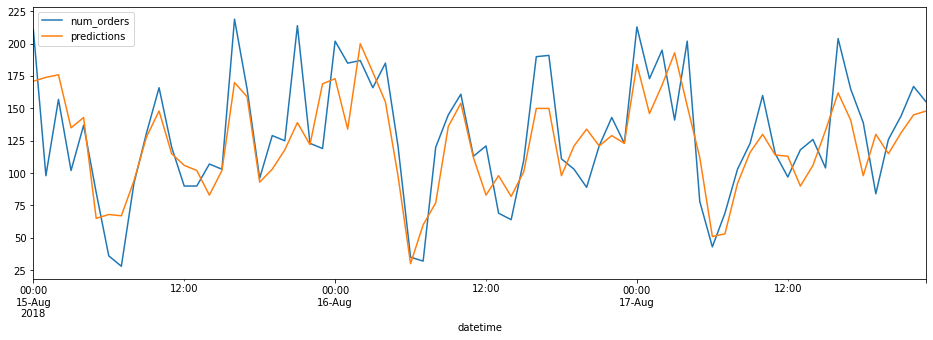

In [ ]:
test_target, predict_GBM_test
graph = test_target.copy()
predictions_taxi = pd.DataFrame(data = predict_GBM_test, columns = ['predictions'], index = test_features.index.copy())
df_out = pd.merge(graph, predictions_taxi, how = 'left', left_index = True, right_index = True)
df_out['predictions'] = df_out['predictions'].astype('int64')
df_out['2018-08-15':'2018-08-17'].plot(figsize=(16,5))

## Итоговый вывод

В ходе работы над проектом был проведено исследование по способам предсказания временных рядов с помощью различных моделей регрессии.

Исходя из финальной таблицы лучше всего предсказала ряд модель LightGBM у которой RMSE = 41,6. Это означает, что модель в среднем ошибается на 41-42 заказа такси в час.

Глядя на последний график можно сказать, что модель достаточно хорошо предсказывает и старается не сильно завышать значения выше target и только в одном месте модель показала завышение - на 6 утра.

